In [1]:
# Residual Network 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4 anndata==0.6.18 numpy==1.16.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
# Create folder to save the results 
import os
dirname = os.getcwd()
print(dirname)
data_dir = os.path.join(dirname, './data/dataset1_uc3/')
if not os.path.exists('./results/'): os.makedirs('./results/')
save_dir = os.path.join(dirname, 'results/')
def save_images(basename):
    if not os.path.exists('./figures/resnet/'): os.makedirs('./figures/resnet/')
    outname = './figures/resnet/' + basename + '.png'
    pl.savefig(outname, dpi=150)
    pl.close()

/data_n3/home/hoatran/python-workspace/dca_scGen


In [3]:
adata = sc.read_h5ad(os.path.join(data_dir,'dataset1_uc3.h5ad'))
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
# adata1.write_h5ad(os.path.join(data_dir,'filtered_dataset1_uc3.h5ad'))
print('Read and filter data')
# adata = sc.read_h5ad(os.path.join(data_dir,'filtered_dataset1_uc3.h5ad'))
adata

filtered out 11 cells that have less than 300 genes expressed
filtered out 9999 genes that are detected in less than 5 cells
Read and filter data


AnnData object with n_obs × n_vars = 565 × 16594 
    obs: 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'

In [4]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
adata.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat
# sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [5]:
# Extract data from batch 1 and batch 2
adata1 = adata[adata.obs['batch']=='Batch1',:].copy()
print(adata1)
adata2 = adata[adata.obs['batch']=='Batch2',:].copy()
print(adata2)

AnnData object with n_obs × n_vars = 282 × 16594 
    obs: 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 283 × 16594 
    obs: 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [6]:
import import_ipynb
from Calibration_Util import ScatterDemo as sd
from Calibration_Util import FileIO as io
import keras.optimizers
from keras.layers import Input, Dense, merge, BatchNormalization, Activation
from keras.models import Model
from keras import callbacks as cb
from Calibration_Util import CostFunctions as cf
from Calibration_Util import Monitoring as mn
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import math
from keras import backend as K
# from numpy import genfromtxt
# from numpy import savetxt
import sklearn.preprocessing as prep
from sklearn import decomposition
from statsmodels.distributions.empirical_distribution import ECDF
from keras import initializers

importing Jupyter notebook from /data_n3/home/hoatran/python-workspace/dca_scGen/Calibration_Util/ScatterDemo.ipynb


Using TensorFlow backend.


In [7]:
import time
from datetime import timedelta

#Define net configuration
mmdNetLayerSizes = [50,50,50]
l2_penalty = 1e-2
#my_init = 'glorot_normal' 
def my_init (shape, name = None):
    return initializations.normal(shape, scale=.1e-4, name=name)
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = epochsDrop
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
patience = 50
epochsDrop = 50.0


In [9]:

print("Nb feature dimensions", adata1.obsm['X_pca'].shape)
space_dim = adata1.obsm['X_pca'].shape[1]
print("Nb feature dimensions", space_dim)

targetBatch = 1
# target_df = data[batches == targetBatch]
target_df = adata1.obsm['X_pca']
print('target data: ',target_df.shape)
print(target_df[1:5,1:5])



calibratedData = np.zeros((0, space_dim))
batch_res = np.zeros((0, 1))
calibratedData = np.concatenate([calibratedData, target_df], axis=0)
batch_res = np.concatenate([batch_res, targetBatch*np.ones((target_df.shape[0],1))], axis=0)

sourceBatch = 2
# load data
# source_df = data[batches == sourceBatch]
source_df = adata2.obsm['X_pca']

print('source data: ',source_df.shape)
source_df[1:5,1:5]

Nb feature dimensions (282, 50)
Nb feature dimensions 50
target data:  (282, 50)
[[ 18930.701   13624.772   15967.964  -17903.68  ]
 [ 18391.127    4812.0454  15506.08   -23778.893 ]
 [ 18149.611    9239.349   17190.422   -9063.652 ]
 [ 21189.76    10826.835    8658.844  -23683.74  ]]
source data:  (283, 50)


array([[  5830.067 ,  21464.902 ,  20147.193 ,  -9434.999 ],
       [ -5872.135 ,  18406.209 ,  18251.693 ,  -7399.3716],
       [  3357.278 ,  17863.115 ,  22118.064 ,  -9571.388 ],
       [-23528.95  ,  19723.76  ,   8056.811 , -10740.323 ]],
      dtype=float32)

In [10]:
from keras.layers import add
# define net    
calibInput = Input(shape=(space_dim,))
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[0], activation='linear',kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1) 

block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(space_dim, activation='linear',kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2) 


block1_output = add([block1_w2, calibInput])
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear',
                  kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1) 

block2_bn2 = BatchNormalization()(block2_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(space_dim, activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2) 
block2_output = add([block2_w2, block1_output])
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear',
                  kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(space_dim, activation='linear',kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2) 
block3_output = add([block3_w2, block2_output])

calibMMDNet = Model(inputs=calibInput, outputs=block3_output)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
#train MMD net
t1 = time.time()
optimizer = keras.optimizers.rmsprop(lr=0.0)
calibMMDNet.compile(optimizer=optimizer, loss=lambda y_true,y_pred: 
               cf.MMD(block3_output,target_df,MMDTargetValidation_split=0.1).KerasCost(y_true,y_pred))
sourceLabels = np.zeros(source_df.shape[0])

setting scales using KNN
[9712.543368809267, 19425.086737618534, 38850.17347523707]
setting all scale weights to 1
Instructions for updating:
keep_dims is deprecated, use keepdims instead


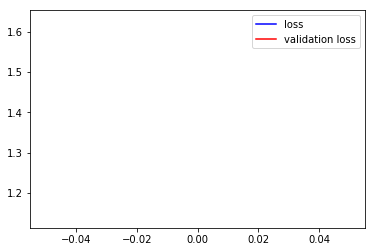

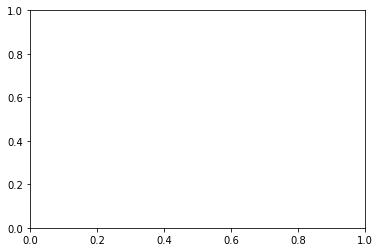

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
calibMMDNet.fit(source_df,sourceLabels,epochs=150,batch_size=30,validation_split=0.15,verbose=0,
           callbacks=[lrate, mn.monitorMMD(source_df, target_df, calibMMDNet.predict),
                      cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')])

In [13]:
afterCalib = calibMMDNet.predict(source_df)
t2 = time.time()
print('Took '+str(timedelta(seconds=t2-t1)))

Took 0:07:26.013416


In [28]:
afterCalib.shape

(283, 50)

In [29]:
print(t1)
print(t2)

1559813189.374488
1559813635.3879037


In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
def myScatterHistDemo(x1,x2, y1,y2,save_file='',axis1='',axis2=''):
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
#     left, width = 0.1, 0.65
#     bottom, height = 0.1, 0.65
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    fig = plt.figure(figsize=(8, 8))
       
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x1, x2, color = 'blue', s=3)
    axScatter.scatter(y1, y2, color = 'red', s=3) 


    # now determine nice limits by hand:
    binwidth = 0.5
    xymax = np.max([np.max(np.fabs(x1)), np.max(np.fabs(x2))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))
    
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x1, bins=bins, color = 'blue', density=True, stacked = True, histtype='step' )
    axHisty.hist(x2, bins=bins, orientation='horizontal', color = 'blue', density=True, stacked = True, histtype='step')
    axHistx.hist(y1, bins=bins, color = 'red', density=True, stacked = True, histtype='step')
    axHisty.hist(y2, bins=bins, orientation='horizontal', color = 'red', density=True, stacked = True, histtype='step')
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
    axHistx.set_xticklabels([])
    axHistx.set_yticklabels([])
    axHisty.set_xticklabels([])
    axHisty.set_yticklabels([])
    axScatter.set_xlabel(axis1, fontsize=15)
    axScatter.set_ylabel(axis2, fontsize=15)
#     save_file = "Data/"+"output_ResNetRNA_"+flname+".png"
    plt.savefig(save_file)
    plt.close(fig)

In [31]:
# from Calibration_Util import ScatterDemo as sd
save_file_bf = os.path.join(dirname, 'figures/resnet/distribution_d1_before.png')
save_file_af = os.path.join(dirname, 'figures/resnet/distribution_d1_after.png')
# The PCs most correlated with the batch are 3 and 5
pc1 = 3
pc2 = 5
myScatterHistDemo(target_df[:,pc1], target_df[:,pc2], source_df[:,pc1], source_df[:,pc2],save_file_bf)
myScatterHistDemo(target_df[:,pc1], target_df[:,pc2], afterCalib[:,pc1], afterCalib[:,pc2],save_file_af)

In [32]:
## quantitative evaluation: MMD ###
# MMD with the scales used for training 
sourceInds = np.random.randint(low=0, high = source_df.shape[0], size = 1000)
targetInds = np.random.randint(low=0, high = target_df.shape[0], size = 1000)
mmd_before = K.eval(cf.MMD(block2_output,target_df).cost(K.variable(value=source_df[sourceInds]), K.variable(value=target_df[targetInds])))
mmd_after = K.eval(cf.MMD(block2_output,target_df).cost(K.variable(value=afterCalib[sourceInds]), K.variable(value=target_df[targetInds])))
print('MMD before calibration: ' + str(mmd_before))
print('MMD after calibration: ' + str(mmd_after))

setting scales using KNN
[9703.755490068768, 19407.510980137537, 38815.02196027507]
setting all scale weights to 1
setting scales using KNN
[9723.281202613209, 19446.562405226417, 38893.124810452835]
setting all scale weights to 1
MMD before calibration: 1.0345438
MMD after calibration: 1.0356758


In [33]:
print(adata1.obs_names[1:3])
print(adata2.obs_names[1:3])
print(target_df.shape)  #adata1
print(afterCalib.shape) # adata2
# 
adata11 = adata1.copy()
adata11.obsm['X_pca'] = target_df
adata22 = adata2.copy()
adata22.obsm['X_pca'] = afterCalib
print(adata11)
print(adata22)
print(adata1.obsm['X_pca'][1:3])
print(adata11.obsm['X_pca'][1:3])

Index(['pDC_P10_S74', 'pDC_P10_S75'], dtype='object', name='index')
Index(['pDC_P13_S50', 'pDC_P13_S51'], dtype='object', name='index')
(282, 50)
(283, 50)
AnnData object with n_obs × n_vars = 282 × 16594 
    obs: 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 283 × 16594 
    obs: 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
[[-1.5581802e+04  1.8930701e+04  1.3624772e+04  1.5967964e+04
  -1.7903680e+04  7.5480630e+03 -3.9162139e+03 -5.8996250e+03
  -1.5050967e+02  2.1841768e+03  9.8678516e+02 -4.5147085e+03
   1.0517926e+03  4.6755645e+03  3.0218535e+03  8.1188940e+02
   9.4550865e+01 -1.3549292e+03  1.4531194e+03 -2.5595376e+03
  -7.7474713e+02  4.7511118e+02 -1.1756813e+03 -6.8567322e+02
  -8.0072729e+02 -8.5618410e+00 -5.7389539e+02  1.8671045e+03
  -1.3244747e+03  6.1697083e+02  3.4846094e+03  7.9617729e+01
  -1.2693726e+02  9.3624768e+0

In [34]:
pca_corrected = np.concatenate([target_df,afterCalib])
print(pca_corrected.shape)
# pca_corrected = np.concatenate([target_df,afterCalib])
# pca_corrected.shape
corrected_adata = adata11.concatenate(adata22, batch_key='Batch')
print(corrected_adata)
corrected_adata.obsm['X_pca'] = pca_corrected   #put normalized values PCs here
save_dir = os.path.join(dirname, './results/resnet_results/')
# corrected_adata.write_csvs(save_dir, skip_data=True)


(565, 50)
AnnData object with n_obs × n_vars = 565 × 16594 
    obs: 'Batch', 'batch', 'cell_type', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'


In [36]:
sc.pp.neighbors(corrected_adata,n_neighbors=10, n_pcs=50)
sc.tl.tsne(corrected_adata, random_state=0, n_pcs=50, perplexity=90)
sc.tl.umap(corrected_adata)
corrected_adata

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.69) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:14.91) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:02.94) --> added
    'X_umap', UMAP coordinates (adata.obsm)


AnnData object with n_obs × n_vars = 565 × 16594 
    obs: 'Batch', 'batch', 'cell_type', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [37]:
import pandas as pd
print(corrected_adata)
colnu = []
for i in range(corrected_adata.obsm['X_umap'].shape[1]):
    colnu.append("UMAP"+str(i+1))
df = pd.DataFrame(corrected_adata.obsm['X_umap'], columns=colnu, index=corrected_adata.obs_names)
df['batch'] = pd.Series(corrected_adata.obs['batch'], index=corrected_adata.obs_names)
df['celltype'] = pd.Series(corrected_adata.obs['cell_type'], index=corrected_adata.obs_names)
df.to_csv(save_dir+'resnet_umap.csv')  

AnnData object with n_obs × n_vars = 565 × 16594 
    obs: 'Batch', 'batch', 'cell_type', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'


In [38]:
colnt = []
for i in range(corrected_adata.obsm['X_tsne'].shape[1]):
    colnt.append("tSNE_"+str(i+1))

df = pd.DataFrame(corrected_adata.obsm['X_tsne'], columns=colnt, index=corrected_adata.obs_names)
df['batch'] = pd.Series(corrected_adata.obs['batch'], index=corrected_adata.obs_names)
df['celltype'] = pd.Series(corrected_adata.obs['cell_type'], index=corrected_adata.obs_names)
df.to_csv(save_dir+'resnet_tsne.csv') 

In [39]:
colnpc = []
for i in range(20):
    colnpc.append("X_pca"+str(i+1))

df = pd.DataFrame(corrected_adata.obsm['X_pca'][:, :20], columns=colnpc, index=corrected_adata.obs_names)
df['batch'] = pd.Series(corrected_adata.obs['batch'], index=corrected_adata.obs_names)
df['celltype'] = pd.Series(corrected_adata.obs['cell_type'], index=corrected_adata.obs_names)
df.to_csv(save_dir+'resnet_pca.csv')

In [40]:
# Function to plot TSNE
def plotTSNE(adata, color_group, n_pcs=20, perplexity=90, save_filename='tsne', use_repx = False):
    #adata.var_names_make_unique()
    if use_repx:
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity, use_rep='X')
    else:    
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity)
    sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
    save_images(save_filename) 
    
def plotUMAP(adata, color_group, save_filename, use_repx = False):
    
    if use_repx:
        sc.pp.neighbors(adata, use_rep='X')
    else:    
        sc.pp.neighbors(adata,n_neighbors=10, n_pcs=20)
        
    sc.tl.umap(adata)
    sc.pl.umap(adata, color = color_group, show=False)
    save_images(save_filename)

color_group = ["batch","cell_type"]    
# Visulization of normalized data
# sc.tl.pca(corrected_adata, svd_solver='arpack')
sc.pp.neighbors(corrected_adata,n_neighbors=10, n_pcs=20)
plotUMAP(corrected_adata, color_group, 'resnet_umap_corrected_dataset1_uc3')
plotTSNE(corrected_adata, color_group, 20, 90, 'resnet_tsne_corrected_dataset1_uc3')

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.69) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.61) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


... storing 'batch' as categorical
... storing 'cell_type' as categorical


    finished (0:00:03.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing tSNE
    using 'X_pca' with n_pcs = 20
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:15.41) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [41]:
corrected_adata.write_h5ad(os.path.join(save_dir,'resnet_dataset1_uc3.h5ad'))
print(t1)
print(t2)
time_taken = t2 - t1
time_taken_mins = divmod(time_taken, 60)
time_taken_hours, rest = divmod( time_taken, 3600)
hours_mins, hours_secs = divmod( rest, 60)
print('Took seconds: '+str(timedelta(seconds=round(time_taken))))
print('Took minutes: '+str(time_taken_mins))
print('Took hours_minutes_seconds: ',str(time_taken_hours),str(hours_mins),str(hours_secs))
usecase_name = 'resnet'
filename = 'resnet_exetime.csv'

data = {'use_case':usecase_name, 'exetime_secs':str(round(time_taken)),
       'exetimehours': str(time_taken_hours),
       'exetimemins': str(hours_mins),
       'exetimesecs':str(round(hours_secs))} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['exetime'])
print(df)
df.to_csv(save_dir+filename) 

1559813189.374488
1559813635.3879037
Took seconds: 0:07:26
Took minutes: (7.0, 26.013415575027466)
Took hours_minutes_seconds:  0.0 7.0 26.013415575027466
        use_case exetime_secs exetimehours exetimemins exetimesecs
exetime   resnet          446          0.0         7.0          26


In [42]:
from sklearn.metrics import silhouette_score
import seaborn as sns
# sc.tl.pca(adata, svd_solver='arpack') #n_comps=20
adata.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat
sil_orig = silhouette_score(adata.obsm.X_pca[:, :20], adata.obs['batch'])
print(np.median(sil_orig))
print('Value of asw original is: ',sil_orig)

sil_corr = silhouette_score(corrected_adata.obsm.X_pca[:, :20], corrected_adata.obs['batch'])
print(np.median(sil_corr))
print('Value of asw correction is: ',sil_corr)

sns.barplot(x=['Filtered', 'Normalized'], y=[sil_orig, sil_corr])
pl.title('Silhouette Coeff Batch ResNet')
save_images('resnet_silhouette_coeff_batch_label')

# # Creates pandas DataFrame. 
usecase_name = 'resnet_asw'
data_sil = {'use_case':usecase_name, 'sil_filtered':sil_orig,
       'sil_corrected': sil_corr}
df_score = pd.DataFrame(data_sil, index =['silscore'])
print(df_score)
print('Save data into directory: ',save_dir)
df_score.to_csv(save_dir+usecase_name+'.csv') 

0.17044699
Value of asw original is:  0.17044699
0.17042197
Value of asw correction is:  0.17042197
            use_case  sil_filtered  sil_corrected
silscore  resnet_asw      0.170447       0.170422
Save data into directory:  /data_n3/home/hoatran/python-workspace/dca_scGen/./results/resnet_results/


In [43]:
save_dir

'/data_n3/home/hoatran/python-workspace/dca_scGen/./results/resnet_results/'